In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
torch_dtype = torch.float16 if device == "cuda" else torch.float32

Could not load bitsandbytes native library: 'NoneType' object has no attribute 'split'
Traceback (most recent call last):
  File "/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
  File "/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/bitsandbytes/cextension.py", line 64, in get_native_library
    cuda_specs = get_cuda_specs()
  File "/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/bitsandbytes/cuda_specs.py", line 39, in get_cuda_specs
    cuda_version_string=(get_cuda_version_string()),
  File "/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/bitsandbytes/cuda_specs.py", line 29, in get_cuda_version_string
    major, minor = get_cuda_version_tuple()
  File "/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/bitsandbytes/cuda_specs.py", line 24, in get_cuda_version_tuple
    major, minor = map(int, torch.version.cuda.split("."))
AttributeError: 'NoneType' 

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch_dtype
)
pipe = pipe.to(device)
pipe.enable_attention_slicing() 
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
pipe.scheduler.set_timesteps(40)

In [5]:
prompt = "a futuristic cityscape"
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

In [6]:
with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

In [7]:
with torch.no_grad():
    latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size
    latents = latents.to(torch_dtype) * pipe.scheduler.init_noise_sigma  # match scheduler expectations

/tmp/ipykernel_10930/1863544359.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size


In [8]:
text_embeddings.requires_grad_(True)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.1643,  0.0385,  0.7491,  ..., -1.2051, -0.5538,  0.5510],
         ...,
         [ 1.0145,  1.4835, -0.6628,  ...,  1.0167, -0.8124, -0.3304],
         [ 1.0173,  1.4762, -0.6511,  ...,  1.0101, -0.8085, -0.3428],
         [ 1.0339,  1.4352, -0.6193,  ...,  0.9290, -0.7245, -0.3472]]],
       requires_grad=True)

In [9]:
x = latents

In [10]:
for i, t in enumerate(pipe.scheduler.timesteps):
    print(i, end = " ")
    model_input = pipe.scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = pipe.unet(model_input, t, encoder_hidden_states=text_embeddings).sample

    scheduler_output = pipe.scheduler.step(noise_pred, t, x)

    x = scheduler_output.prev_sample

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [11]:
with torch.no_grad():
    image = pipe.vae.decode(x / 0.18215).sample

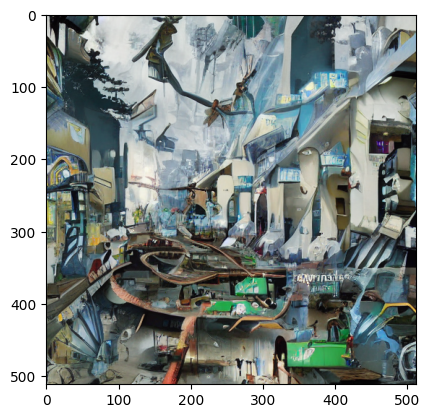

In [13]:
import torchvision
grid = torchvision.utils.make_grid(image, nrow=1)
import matplotlib.pyplot as plt
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

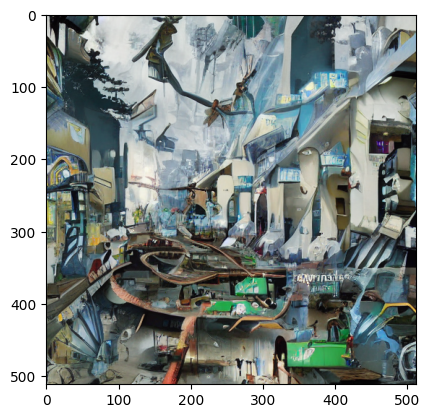

In [17]:
import numpy as np
img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32) # Squeeze if you want to remove the channel dimension
img_np = (img_np + 1.0) / 2.0
img_np = np.clip(img_np, 0, 1)
import matplotlib.pyplot as plt
# Plot using matplotlib
plt.imshow(img_np, cmap='gray')